In [1]:
import sys
sys.path.insert(1, '../')
from torchvision.datasets import MNIST
from autograd import tensor
from autograd import modules
from autograd.dataloader import DataLoader
from autograd.losses import CrossEntropyLoss, MSELoss
import logging
import logging_settings
import numpy as np

In [2]:
mnist_trainset = MNIST(root='./data', train=False,download=True,transform=None)
mnist_testset = MNIST(root='./data', train=False, download=True, transform=None)

In [3]:
class MNISTDataset:
    def __init__(self, mnist):
        self.mnist = mnist
    def __len__(self):
        return len(self.mnist)
    def __getitem__(self, idx):
        pil_image, label = self.mnist[idx]
        label_onehot = np.zeros(10,dtype='float64')
        label_onehot[label] = 1
        return np.asarray(pil_image).astype('float64') / 255, label_onehot

In [4]:
train_dataset = MNISTDataset(mnist_trainset)
test_dataset = MNISTDataset(mnist_testset)
train_dataloader = DataLoader(train_dataset)
test_dataloader = DataLoader(test_dataset)

In [6]:
model = modules.Sequential(
    [
        modules.Flatten(),
        modules.Linear(784, 250),
        modules.ReLU(),
        modules.Linear(250, 10),
        modules.Softmax()
    ]
)

In [7]:
loss_function = CrossEntropyLoss()
lr = 0.01
loss_log = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}

In [ ]:
# train for X epochs:
    # train and save results model implements train (optimizer)
    # test and save results
    # print results

In [ ]:
# Model wrapper (Model Trainer)
# Keeps logs, optimizer, inputs to model from dataloader
# function train: inputs dataloader, 

In [ ]:
class ModelTrainer:
    def __init__(self, model, optimizer, loss, metrics):
        '''
        metrics are loss (default) and accuracy 
        '''
        if 'loss' not in metrics:
            metrics.append('loss')

        self.model = model
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.train_log = {metric:[] for metric in metrics}
        self.test_log = {metric:[] for metric in metrics}
    def train(self, dataloader):
        '''
        Trains self.model for one epoch
        dataloader returns a tuple of (arguments, targets)
        Assumed that the last element are targets, rest of the elements are passed into self.model 
        '''
        for metric in self.metrics:
            self.train_log[metric].append(0)
        for data in dataloader:
            output = self.model(*data[:-1])
            loss = self.loss(output, data[-1])

            self.train_log['loss'][-1] += loss.item() * len(data[-1]) # Assumes loss is averaged
            if 'accuracy' in self.metrics:
                self.train_log['accuracy'][-1] += (output.asarray().argmax(-1) == data[-1].argmax(-1)).asarray().sum()

            loss.backward()
            self.optimizer.step()
        for metric in self.metrics:
            self.train_log[metric][-1] /= len(dataloader.dataset)
        

In [11]:
for epoch in range(20):
    train_loss, test_loss = 0, 0
    train_ncorrect, test_ncorrect = 0,0
    print(f"Epoch {epoch+1}")
    for x, y in train_dataloader:
        yhat = model(tensor.tensor(x))
        loss = loss_function(yhat, tensor.tensor(y))
        train_loss += loss.item() * len(y)

        train_ncorrect += (yhat.asarray().argmax(axis=-1) == y.argmax(axis=-1)).sum()
        loss.backward()
        for parameter in model.parameters():
            parameter -= lr * parameter.grad
    train_loss /= len(train_dataloader.dataset)

    for x, y in test_dataloader:
        yhat = model(x)
        loss = loss_function(yhat, y)
        test_loss += loss.item() * len(y)
        loss.clear_graph()
        test_ncorrect += (yhat.asarray().argmax(axis=-1) == y.argmax(axis=-1)).sum()
        
    test_loss /= len(test_dataloader.dataset)
    loss_log['train_loss'].append(train_loss)
    loss_log['test_loss'].append(test_loss)
    loss_log['train_accuracy'].append(train_ncorrect / len(train_dataloader.dataset))
    loss_log['test_accuracy'].append(test_ncorrect / len(test_dataloader.dataset))

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


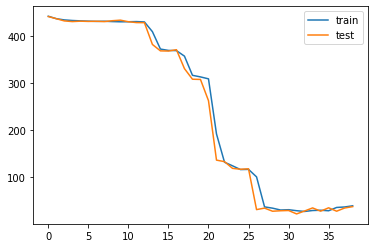

In [12]:
import matplotlib.pyplot as plt
plt.plot(loss_log['train_loss'][1:], label='train')
plt.plot(loss_log['test_loss'][1:], label='test')
plt.legend()

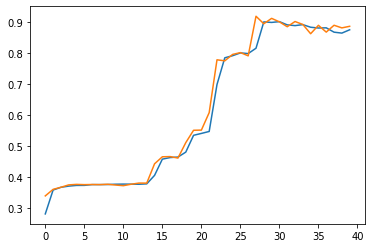

In [13]:
import matplotlib.pyplot as plt
plt.plot(loss_log['train_accuracy'], label='train')
plt.plot(loss_log['test_accuracy'], label='test')

In [15]:
max(loss_log['test_accuracy'])

0.9175